In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar o DataFrame
df = pd.read_excel('C:/Users/Patyc/OneDrive/Desktop/Dissertation/Data/Skin_clean and treated/Skin_clean.xlsx')

# Converter a data para datetime e ordenar de forma crescente
df['Screening_date'] = pd.to_datetime(df['Screening_date'])
df = df.sort_values(by='Screening_date')

# 3. Contar o número de rastreios por semana
week_screenings = df.resample('W-Mon', on='Screening_date').size()

# 4. Criar um DataFrame com a nova variável
df_week = week_screenings.reset_index()
df_week.columns = ['Semana', 'week_screenings']

# Exibir o resultado
print(df_week)

        Semana  week_screenings
0   2022-03-07               92
1   2022-03-14                0
2   2022-03-21               62
3   2022-03-28               90
4   2022-04-04               69
..         ...              ...
108 2024-04-01              198
109 2024-04-08              242
110 2024-04-15                0
111 2024-04-22              186
112 2024-04-29              184

[113 rows x 2 columns]


# ANÁLISE WEEK_SCREENINGS

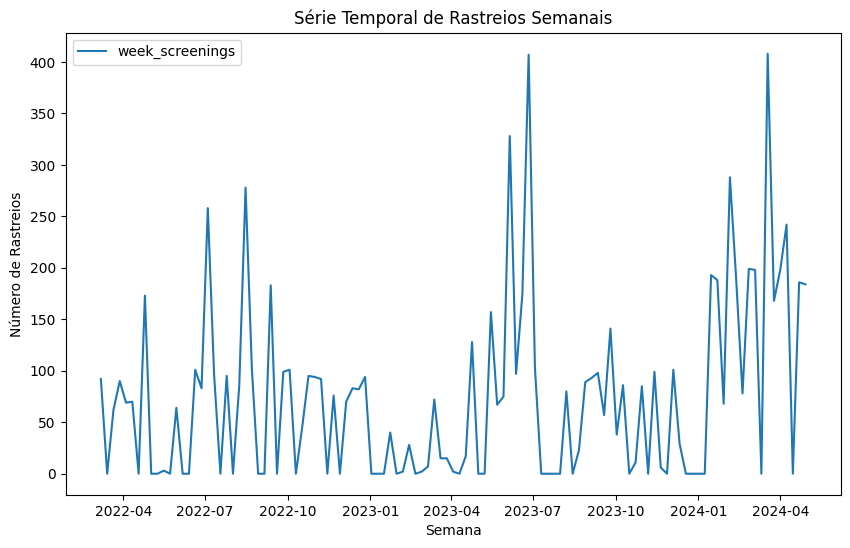

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_week['Semana'], df_week['week_screenings'], label='week_screenings')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Série Temporal de Rastreios Semanais')
plt.legend()
plt.show()

Estatísticas Descritivas

In [4]:
print(df_week['week_screenings'].describe())

count    113.000000
mean      74.283186
std       88.143397
min        0.000000
25%        0.000000
50%       67.000000
75%       99.000000
max      408.000000
Name: week_screenings, dtype: float64


Variabilidade Alta: A alta variabilidade (indicada pelo desvio padrão elevado e pela diferença entre os quartis e o valor máximo) sugere que o modelo pode precisar capturar bem os picos e vales na série temporal. Isso pode ser um desafio para modelos simples como AR ou MA, e pode exigir a consideração de um modelo mais complexo ou a adição de componentes sazonais.

Dados Esparsos: A presença de semanas com 0 rastreios (indicada pelo valor mínimo e pelo 25% quartil) pode indicar períodos de inatividade ou sazonalidade. Dependendo da frequência desses zeros, pode ser necessário ajustar o modelo para lidar com essa esparsidade.

Sazonalidade ou Eventos Excepcionais: O valor máximo (408 rastreios) está muito acima da média, o que pode indicar um evento excepcional. Se esses picos não forem recorrentes, pode ser necessário considerar técnicas para tratar outliers ou eventos excepcionais na modelagem.

Estacionariedade

In [5]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_week['week_screenings'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.716829078702641
p-value: 0.0038825696964342694


Com um p-valor de 0.00388, a hipótese nula de que a série temporal não é estacionária pode ser rejeitada. Isso significa que a série week_screenings é estacionária com um nível de confiança de 99,61%. Não é necessário aplicar diferenciação adicional (d=0 no ARIMA), o que simplifica a modelagem.

Decomposição da série temporal

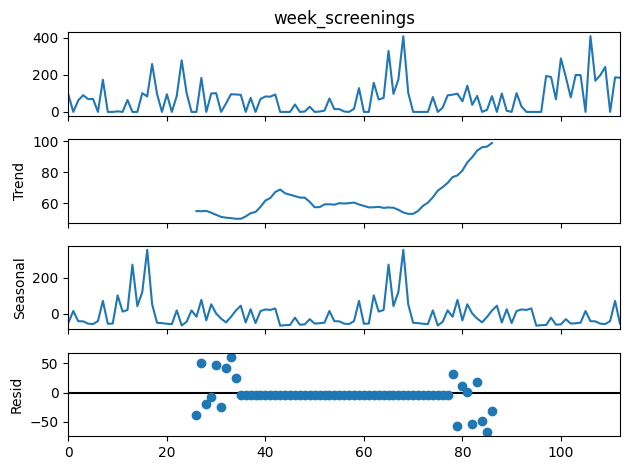

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_week['week_screenings'], model='additive', period=52)  # Assumindo dados semanais
decomposition.plot()
plt.show()

Série Original (week_screenings): Mostra a série temporal dos rastreios semanais, com flutuações significativas e alguns picos marcantes.

Tendência (Trend): A componente de tendência mostra uma tendência de crescimento ao longo do tempo, especialmente mais recente. Isso indica que o número de rastreios tende a aumentar.

Sazonalidade (Seasonal): A componente sazonal revela um padrão sazonal com variações recorrentes, embora não seja muito forte. Isso pode significar que há uma sazonalidade anual ou semestral nos dados.

Resíduos (Resid): Os resíduos mostram o que resta após a remoção da tendência e sazonalidade. A maior parte dos resíduos parece estar centrada em torno de zero, o que é bom, mas há alguns pontos fora da linha que podem indicar outliers.

Autocorrelação e Parcial Autocorrelação

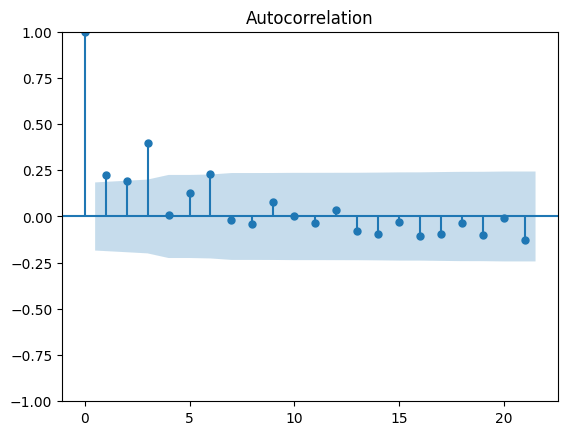

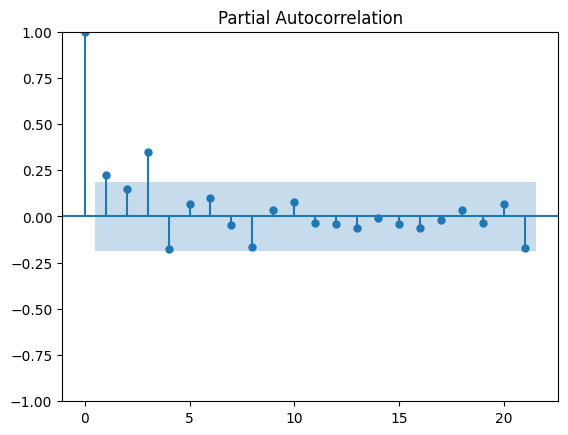

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_week['week_screenings'])
plot_pacf(df_week['week_screenings'])
plt.show()

# MODELO AR

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg

Modelo: AR(1)
MAE: 105.53530266811977
MSE: 16666.327814850356
RMSE: 129.09813249946862
R2: -0.3562040774408537
ME: 67.02051102544236
MAV: 126.78260869565217
MPV: inf
RME: -inf
RMAE: inf


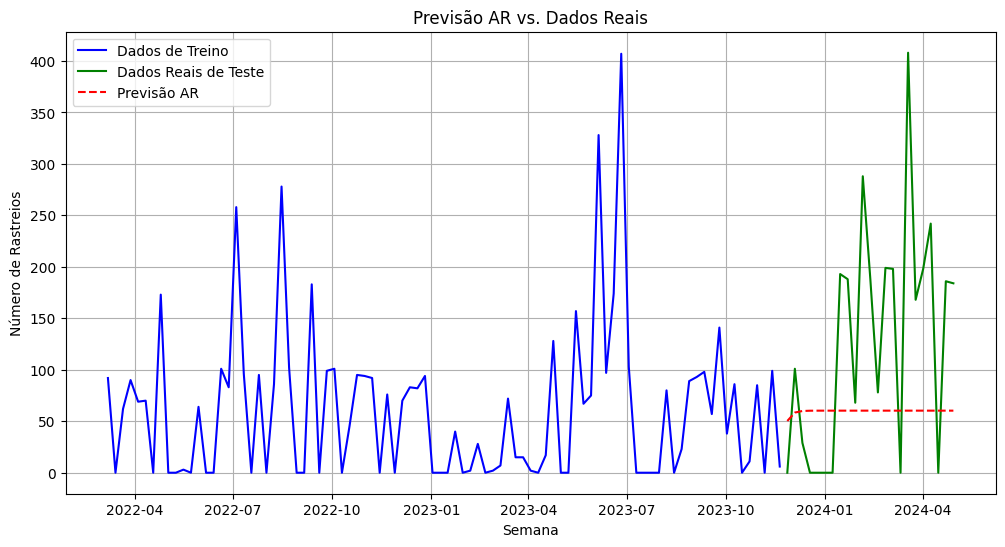

In [9]:
# # 1. Dividir os dados em treino (antes de 2024) e teste (2024)
# train = df_week[df_week['Semana'] < '2024-01-01']
# y_train = train['week_screenings']
# test = df_week[df_week['Semana'] >= '2024-01-01']
# y_test = test['week_screenings']

# 1. Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(df_week) * 0.8)
y_train = df_week['week_screenings'][:train_size]
y_test = df_week['week_screenings'][train_size:]

# # 2. Criar e ajustar o modelo AR
# model = AutoReg(train['week_screenings'], lags=1)  # lags=1 para um modelo AR(1)
# model_fit = model.fit()

# 2. Criar e ajustar o modelo AR
model = AutoReg(y_train, lags=1)  # lags=1 para um modelo AR(1)
model_fit = model.fit()

# 3. Fazer previsões
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: AR(1)")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# # 5. Plotar os resultados split date
# plt.figure(figsize=(12, 6))
# plt.plot(test['Semana'], y_test, label='Dados Reais de Teste', color='green')
# plt.plot(test['Semana'], y_pred, label='Previsão AR', color='red', linestyle='--')
# plt.xlabel('Semana')
# plt.ylabel('Número de Rastreios')
# plt.title('Previsão AR vs. Dados Reais')
# plt.legend()
# plt.grid(True)
# plt.show()

# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão AR', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão AR vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()


MODELO AR SEM OUTLIERS

Modelo: AR(1) sem Outliers
MAE: 89.08088465573177
MSE: 10808.734438631403
RMSE: 103.96506354844114
R2: -0.33785560326644326
ME: 29.084261313158297
MAV: 101.18181818181819
MPV: inf
RME: -inf
RMAE: inf


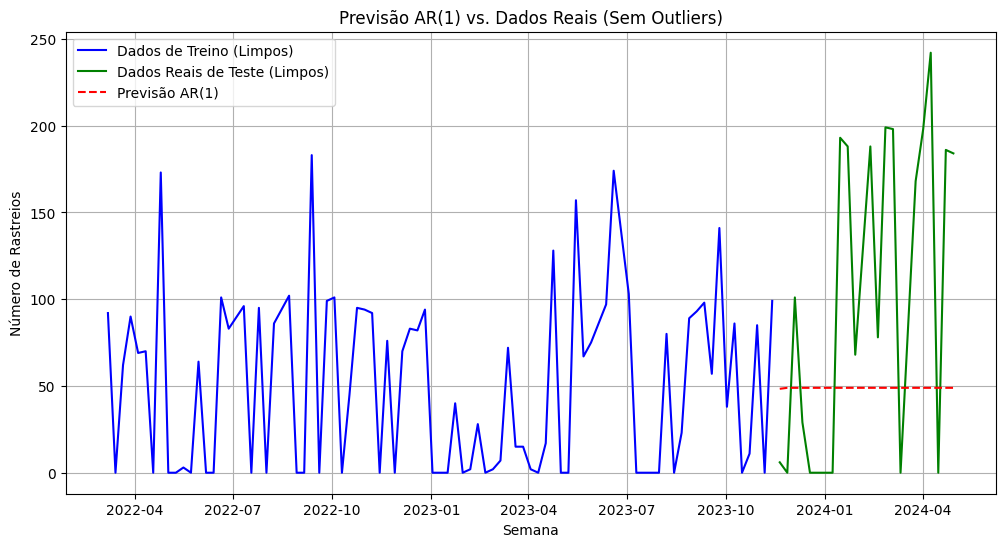

In [10]:
# 1. Identificação de Outliers usando o método IQR
Q1 = df_week['week_screenings'].quantile(0.25)
Q3 = df_week['week_screenings'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2. Remoção de Outliers
df_week_clean = df_week[(df_week['week_screenings'] >= lower_bound) & (df_week['week_screenings'] <= upper_bound)]

# 3. Dividir os dados limpos em treino (80%) e teste (20%)
train_size = int(len(df_week_clean) * 0.8)
y_train = df_week_clean['week_screenings'][:train_size]
y_test = df_week_clean['week_screenings'][train_size:]

# 4. Criar e ajustar o modelo AR(1)
model = AutoReg(y_train, lags=1)
model_fit = model.fit()

# 5. Fazer previsões
y_pred = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 6. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: AR(1) sem Outliers")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 7. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred, label='Previsão AR(1)', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão AR(1) vs. Dados Reais (Sem Outliers)')
plt.legend()
plt.grid(True)
plt.show()

# MODELO ARMA

Caso particular do ARIMA em que 'd' é 0

MODELO ARMA MELHORES VALORES DOS PARÂMETROS

Melhor combinação de (p, d, q): (0, 0, 3) com AIC: 1033.8723638296233
Modelo: ARMA
MAE: 103.50026054307283
MSE: 16473.70065128613
RMSE: 128.3499148861663
R2: -0.3405292540752114
ME: 67.33420009943349
MAV: 126.78260869565217
MPV: inf
RME: -inf
RMAE: inf


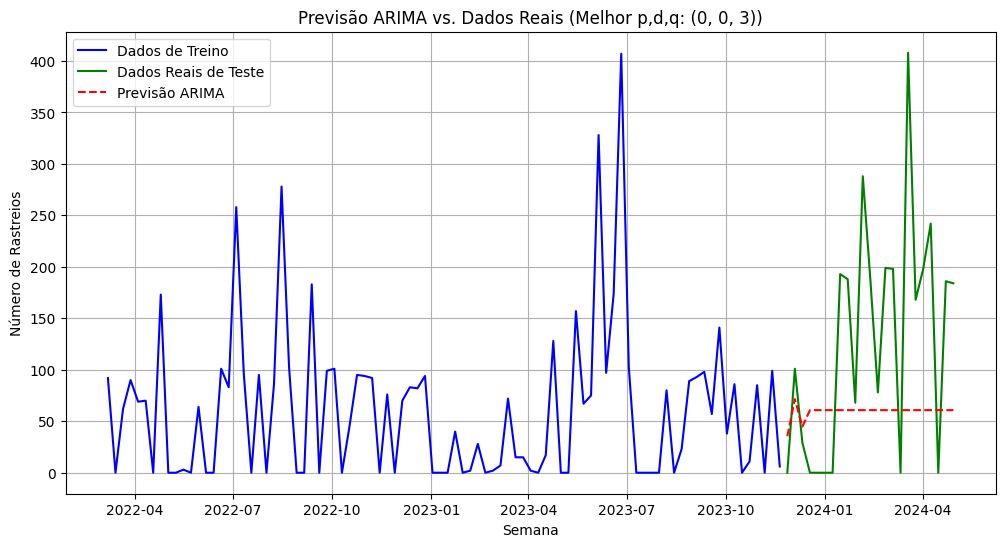

In [11]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

# 1. Definir os intervalos de valores para p e q
p = range(0, 4)  # Exemplo: Testar valores de 0 a 3 para p
d = [0]  # Mantendo d=0, pois sabemos que a série é estacionária
q = range(0, 4)  # Exemplo: Testar valores de 0 a 3 para q

# 2. Criar a lista de todas as combinações possíveis de p, d, q
pdq = list(itertools.product(p, d, q))

# 3. Dividir os dados em treino (80%) e teste (20%)
train_size = int(len(df_week) * 0.8)
y_train = df_week['week_screenings'][:train_size]
y_test = df_week['week_screenings'][train_size:]

# 4. Grid Search para encontrar a melhor combinação de p, d, q
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(y_train, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
            best_model = model_fit
    except:
        continue

# 5. Exibir os melhores parâmetros encontrados
print(f"Melhor combinação de (p, d, q): {best_pdq} com AIC: {best_aic}")

# 6. Fazer previsões com o melhor modelo
y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 7. Avaliar o modelo
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 6. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: ARMA")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 8. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão ARIMA', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title(f'Previsão ARIMA vs. Dados Reais (Melhor p,d,q: {best_pdq})')
plt.legend()
plt.grid(True)
plt.show()

MODELO ARMA MELHORES PARÂMETROS SEM OUTLIERS

Melhor combinação de (p, d, q): (0, 0, 0) com AIC: 911.8881392811828
Modelo: ARMA sem Outliers
MAE: 89.01390446889359
MSE: 10758.06962983632
RMSE: 103.72111467698522
R2: -0.3315845454733435
ME: 28.57647457891477
MAV: 101.18181818181819
MPV: inf
RME: -inf
RMAE: inf


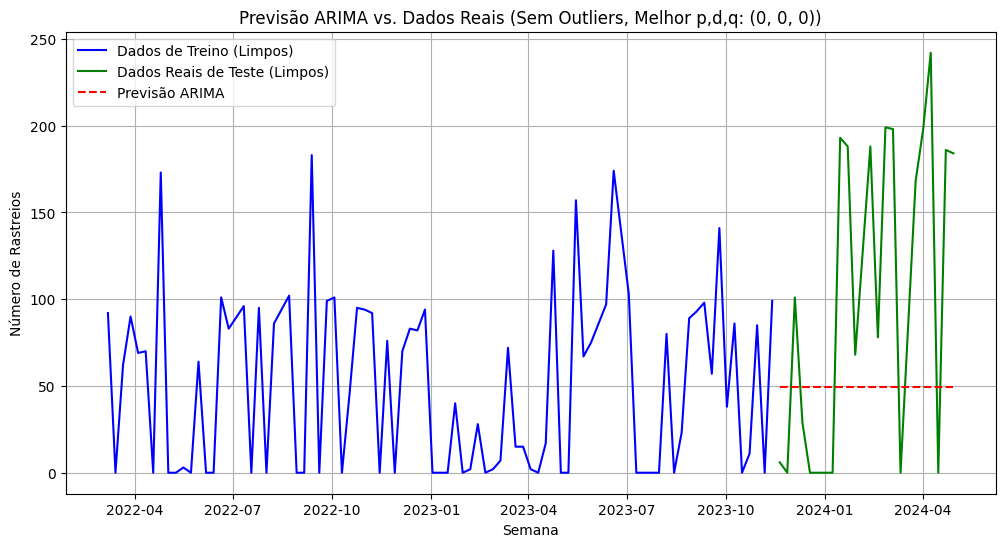

In [12]:
# 1. Identificação de Outliers usando o método IQR
Q1 = df_week['week_screenings'].quantile(0.25)
Q3 = df_week['week_screenings'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 2. Remoção de Outliers
df_week_clean = df_week[(df_week['week_screenings'] >= lower_bound) & (df_week['week_screenings'] <= upper_bound)]

# 3. Definir os intervalos de valores para p e q
p = range(0, 4)  # Testar valores de 0 a 3 para p
d = [0]  # Mantendo d=0, pois a série é estacionária
q = range(0, 4)  # Testar valores de 0 a 3 para q

# 4. Criar a lista de todas as combinações possíveis de p, d, q
pdq = list(itertools.product(p, d, q))

# 5. Dividir os dados limpos em treino (80%) e teste (20%)
train_size = int(len(df_week_clean) * 0.8)
y_train = df_week_clean['week_screenings'][:train_size]
y_test = df_week_clean['week_screenings'][train_size:]

# 6. Grid Search para encontrar a melhor combinação de p, d, q
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(y_train, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
            best_model = model_fit
    except:
        continue

# 7. Exibir os melhores parâmetros encontrados
print(f"Melhor combinação de (p, d, q): {best_pdq} com AIC: {best_aic}")

# 8. Fazer previsões com o melhor modelo
y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# 9. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

# Imprimir as métricas
print("Modelo: ARMA sem Outliers")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 10. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred, label='Previsão ARIMA', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title(f'Previsão ARIMA vs. Dados Reais (Sem Outliers, Melhor p,d,q: {best_pdq})')
plt.legend()
plt.grid(True)
plt.show()


# MODELO SARIMA

MODELO SARIMA MELHORES PARÂMETROS

Melhor combinação de (p, d, q): (1, 0, 2) e sazonal (P, D, Q, m): (0, 1, 1, 7) com AIC: 860.7537911363921
Modelo: SARIMA
MAE: 104.39442404224343
MSE: 16727.769434878846
RMSE: 129.33587837440487
R2: -0.3612038216276301


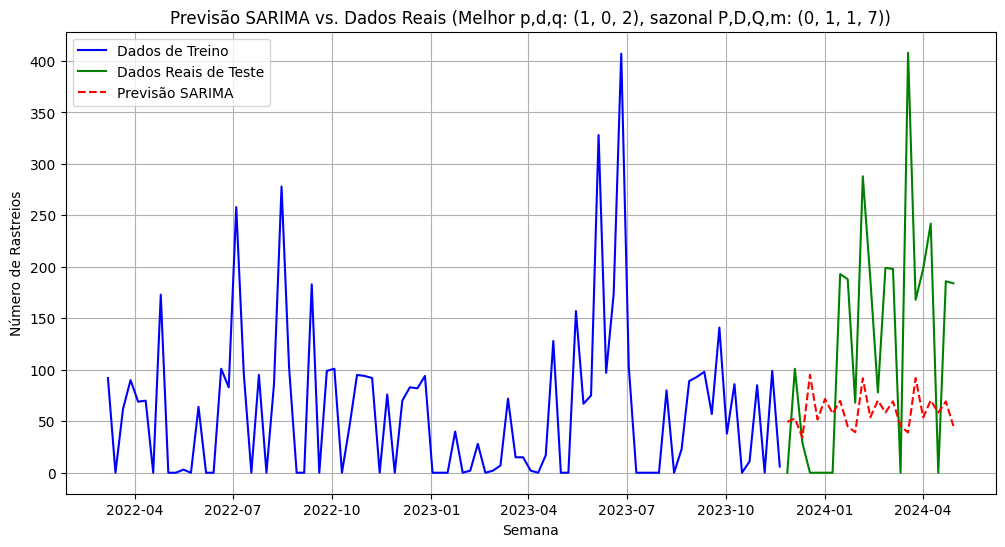

In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ignorar avisos para modelos mal ajustados
warnings.filterwarnings("ignore")

# Definir os intervalos de valores para p, d, q, P, D, Q, e m
p = range(0, 3)
d = [0]
q = range(0, 3)
P = range(0, 2)
D = [0, 1]  # Testando tanto D=0 quanto D=1
Q = range(0, 2)
m = 7  # Sazonalidade semanal

# Criar a lista de todas as combinações possíveis de (p, d, q) e (P, D, Q, m)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [m]))

# Dividir os dados em treino (80%) e teste (20%)
train_size = int(len(df_week) * 0.8)
y_train = df_week['week_screenings'][:train_size]
y_test = df_week['week_screenings'][train_size:]

# Grid Search para encontrar a melhor combinação de p, d, q, P, D, Q, m
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y_train, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_pdq = param
                best_seasonal_pdq = seasonal_param
                best_model = model_fit
        except:
            continue

# Exibir os melhores parâmetros encontrados
print(f"Melhor combinação de (p, d, q): {best_pdq} e sazonal (P, D, Q, m): {best_seasonal_pdq} com AIC: {best_aic}")

# Fazer previsões com o melhor modelo
y_pred = best_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)

# Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Imprimir as métricas
print("Modelo: SARIMA")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão SARIMA', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title(f'Previsão SARIMA vs. Dados Reais (Melhor p,d,q: {best_pdq}, sazonal P,D,Q,m: {best_seasonal_pdq})')
plt.legend()
plt.grid(True)
plt.show()


# MODELO ES

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Dividir os dados em treino e teste (80% treino, 20% teste)
train_size = int(len(df_week) * 0.8)
y_train = df_week['week_screenings'][:train_size]
y_test = df_week['week_screenings'][train_size:]

Simple Exponential Smoothing (SES)

Modelo: SES
MAE: 108.58430190817407
MSE: 17955.11071386834
RMSE: 133.99668172707987
R2: -0.4610773669861863
ME: 75.27388639393841
MAV: 126.78260869565217
MPV: inf
RME: -inf
RMAE: inf


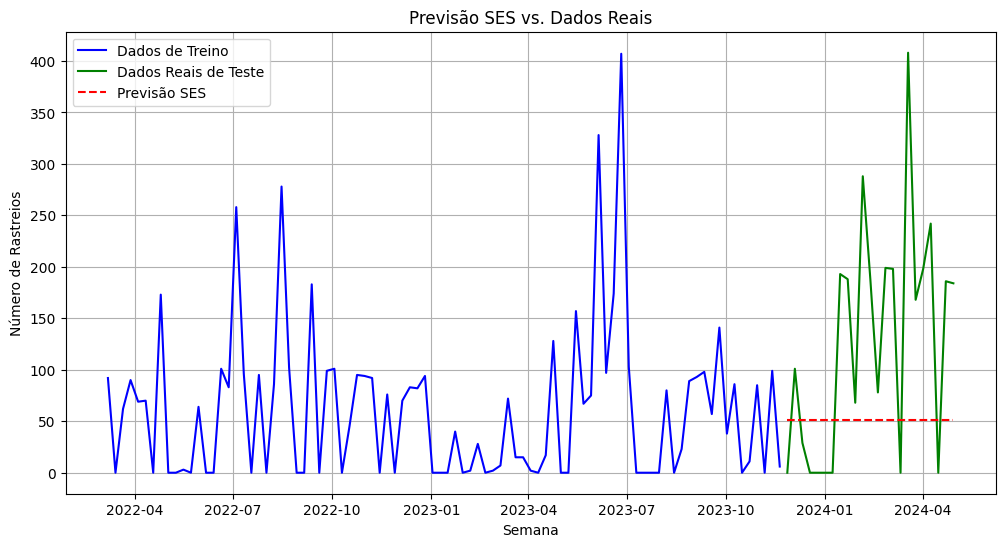

In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# 2. Criar e ajustar o modelo SES
model = SimpleExpSmoothing(y_train).fit()

# 3. Fazer previsões
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: SES")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão SES', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão SES vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()

Holt’s Linear Trend Model (Double Exponential Smoothing)

Modelo: HLTM
MAE: 110.22890813979473
MSE: 18723.007295511372
RMSE: 136.8320404565808
R2: -0.5235641059155156
ME: 79.7819021251867
MAV: 126.78260869565217
MPV: inf
RME: -inf
RMAE: inf


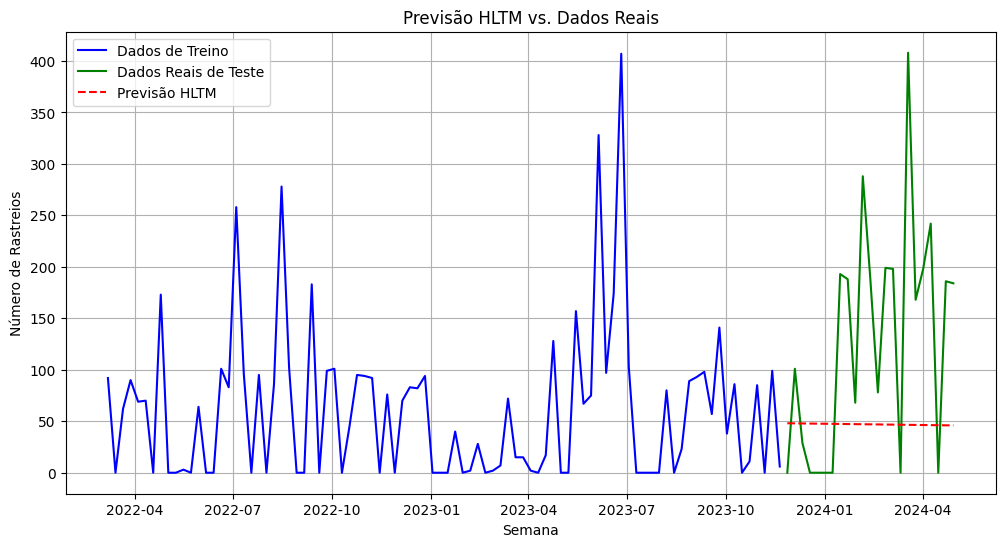

In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 2. Criar e ajustar o modelo Holt's Linear Trend (Double Exponential Smoothing)
model = ExponentialSmoothing(y_train, trend='add').fit()

# 3. Fazer previsões
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: HLTM")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão HLTM', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão HLTM vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()

Holt-Winters Exponential Smoothing (Triple Exponential Smoothing)

Modelo: HWES
MAE: 112.0067485379472
MSE: 20137.301524196904
RMSE: 141.90596014331783
R2: -0.6386507417331135
ME: 87.29425918471817
MAV: 126.78260869565217
MPV: inf
RME: -inf
RMAE: inf


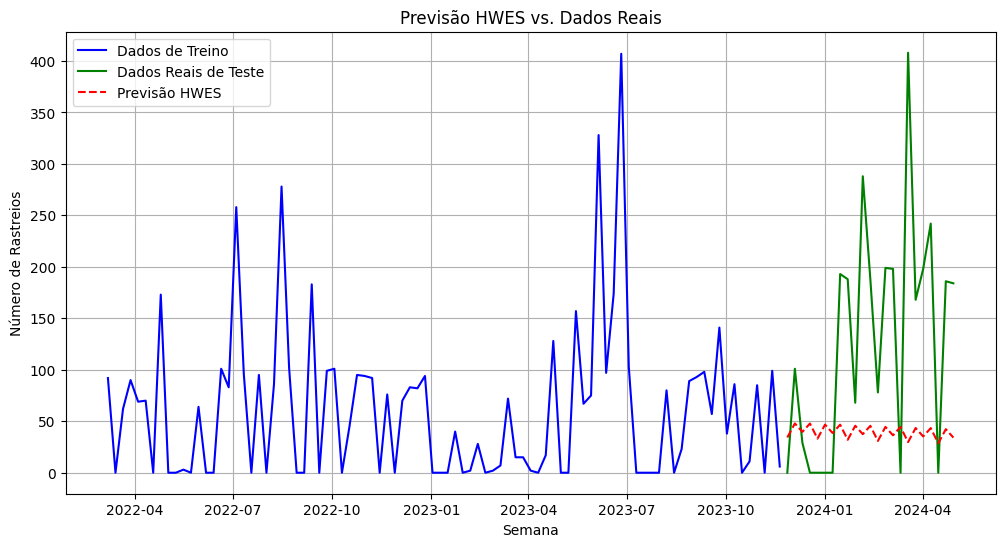

In [7]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 2. Criar e ajustar o modelo Holt-Winters (Triple Exponential Smoothing)
# Definindo sazonalidade com período de 52 semanas (ajuste conforme necessário)
model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=4).fit()

# 3. Fazer previsões
y_pred = model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# 4. Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
me = np.mean(y_test - y_pred)
mav = np.mean(np.abs(y_test))
mpv = np.mean(np.abs((y_test - y_pred) / y_test))
rme = np.mean((y_test - y_pred) / y_test)
rmae = np.mean(np.abs(y_test - y_pred) / np.abs(y_test))

print("Modelo: HWES")
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
print(f'ME: {me}')
print(f'MAV: {mav}')
print(f'MPV: {mpv}')
print(f'RME: {rme}')
print(f'RMAE: {rmae}')

# 5. Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week['Semana'][:train_size], y_train, label='Dados de Treino', color='blue')
plt.plot(df_week['Semana'][train_size:], y_test, label='Dados Reais de Teste', color='green')
plt.plot(df_week['Semana'][train_size:], y_pred, label='Previsão HWES', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão HWES vs. Dados Reais')
plt.legend()
plt.grid(True)
plt.show()

REMOVER OUTLIERS

In [19]:
# Identificação de Outliers usando o método IQR
Q1 = df_week['week_screenings'].quantile(0.25)
Q3 = df_week['week_screenings'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remoção de Outliers
df_week_clean = df_week[(df_week['week_screenings'] >= lower_bound) & (df_week['week_screenings'] <= upper_bound)]

# Dividir os dados limpos em treino (80%) e teste (20%)
train_size = int(len(df_week_clean) * 0.8)
y_train = df_week_clean['week_screenings'][:train_size]
y_test = df_week_clean['week_screenings'][train_size:]

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Modelo SES: Suavização Exponencial Simples (Sem Outliers)
MAE: 87.93850544622009
MSE: 10180.78425038826
RMSE: 100.89987240025758
R2: -0.2601308073911104


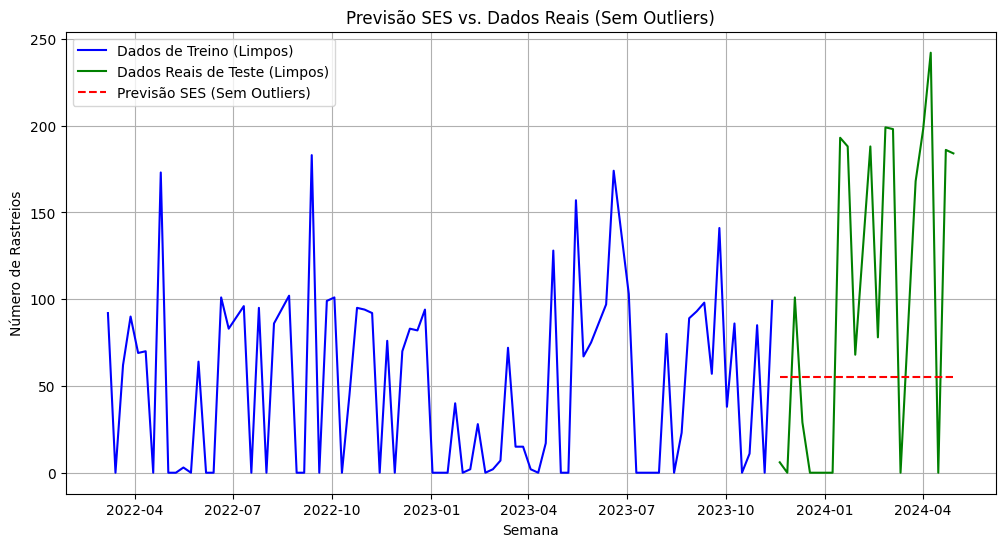

In [20]:
# Criar e ajustar o modelo SES
model_ses = SimpleExpSmoothing(y_train).fit()

# Fazer previsões
y_pred_ses = model_ses.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Avaliar o modelo
mae_ses = mean_absolute_error(y_test, y_pred_ses)
mse_ses = mean_squared_error(y_test, y_pred_ses)
rmse_ses = np.sqrt(mse_ses)
r2_ses = r2_score(y_test, y_pred_ses)

print("Modelo SES: Suavização Exponencial Simples (Sem Outliers)")
print(f'MAE: {mae_ses}')
print(f'MSE: {mse_ses}')
print(f'RMSE: {rmse_ses}')
print(f'R2: {r2_ses}')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred_ses, label='Previsão SES (Sem Outliers)', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão SES vs. Dados Reais (Sem Outliers)')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Modelo Holt: Suavização Exponencial com Tendência Linear (Sem Outliers)
MAE: 86.3078457758371
MSE: 9605.840962947888
RMSE: 98.00939221803127
R2: -0.18896696272180558


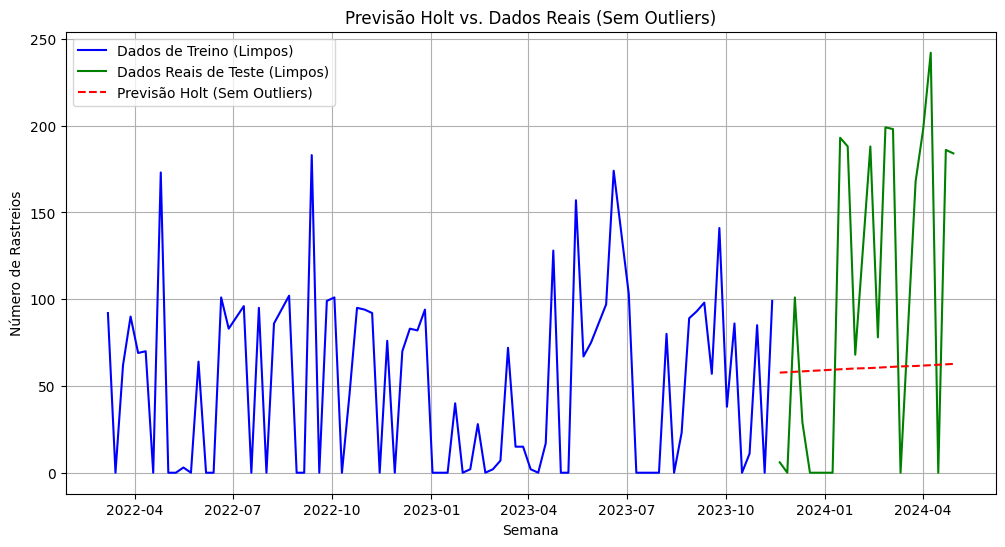

In [21]:
# Criar e ajustar o modelo Holt's Linear Trend
model_holt = ExponentialSmoothing(y_train, trend='add', seasonal=None).fit()

# Fazer previsões
y_pred_holt = model_holt.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Avaliar o modelo
mae_holt = mean_absolute_error(y_test, y_pred_holt)
mse_holt = mean_squared_error(y_test, y_pred_holt)
rmse_holt = np.sqrt(mse_holt)
r2_holt = r2_score(y_test, y_pred_holt)

print("Modelo Holt: Suavização Exponencial com Tendência Linear (Sem Outliers)")
print(f'MAE: {mae_holt}')
print(f'MSE: {mse_holt}')
print(f'RMSE: {rmse_holt}')
print(f'R2: {r2_holt}')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred_holt, label='Previsão Holt (Sem Outliers)', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão Holt vs. Dados Reais (Sem Outliers)')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Patyc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Modelo Holt-Winters: Suavização Exponencial com Sazonalidade (Sem Outliers)
MAE: 82.96571053724173
MSE: 8884.34030178453
RMSE: 94.25677854554827
R2: -0.09966291812913775


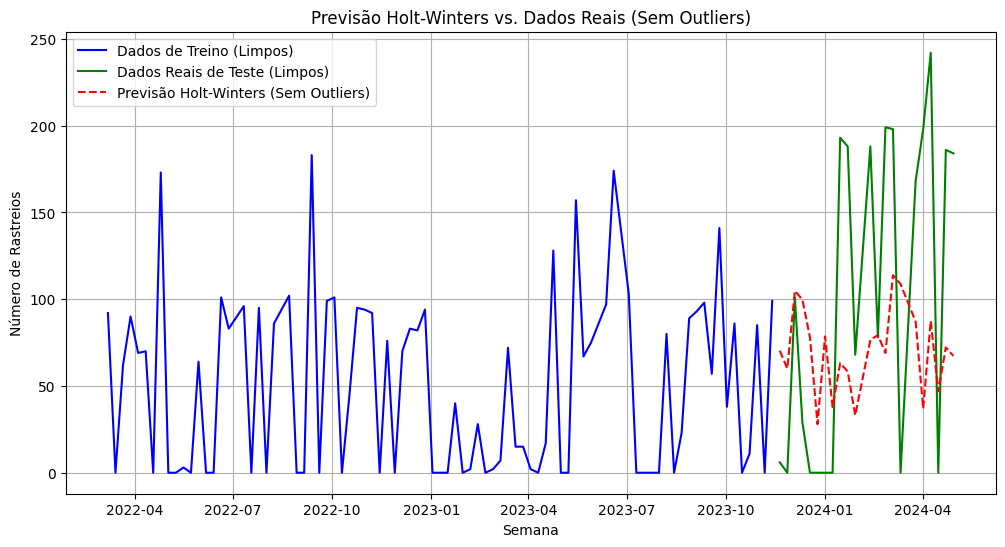

In [28]:
# Criar e ajustar o modelo Holt-Winters (Triple Exponential Smoothing)
# Usar sazonalidade com um período ajustado conforme necessário, por exemplo, 12 semanas
model_hw = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12).fit()

# Fazer previsões
y_pred_hw = model_hw.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Avaliar o modelo
mae_hw = mean_absolute_error(y_test, y_pred_hw)
mse_hw = mean_squared_error(y_test, y_pred_hw)
rmse_hw = np.sqrt(mse_hw)
r2_hw = r2_score(y_test, y_pred_hw)

print("Modelo Holt-Winters: Suavização Exponencial com Sazonalidade (Sem Outliers)")
print(f'MAE: {mae_hw}')
print(f'MSE: {mse_hw}')
print(f'RMSE: {rmse_hw}')
print(f'R2: {r2_hw}')

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df_week_clean['Semana'][:train_size], y_train, label='Dados de Treino (Limpos)', color='blue')
plt.plot(df_week_clean['Semana'][train_size:], y_test, label='Dados Reais de Teste (Limpos)', color='green')
plt.plot(df_week_clean['Semana'][train_size:], y_pred_hw, label='Previsão Holt-Winters (Sem Outliers)', color='red', linestyle='--')
plt.xlabel('Semana')
plt.ylabel('Número de Rastreios')
plt.title('Previsão Holt-Winters vs. Dados Reais (Sem Outliers)')
plt.legend()
plt.grid(True)
plt.show()
